In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
%matplotlib inline

# Step 1: Load the datasets
df = pd.read_csv('datasets/survey_results_public.csv')
schema = pd.read_csv('datasets/survey_results_schema.csv')


# Step 5: Extract features and output feature for analysis
Output_name = 'JobSatisfaction'
df = df[df['Country'] == "Turkey"]
df = df[df['EmploymentStatus'] == "Employed full-time"]
#df = df[df['Gender'] == "Male"]
work_env = df[['ChangeWorld','ChallengeMyself', 'ProblemSolving', 'Overpaid','SeriousWork','CompetePeers','LearningNewTech', Output_name]]
#RightWrongWay is not effective
#work_env = work_env[work_env['Country']== "United States"]
#print(df['Country'].unique())
#work_env = df[['LearningNewTech', 'ProblemSolving', Output_name]]


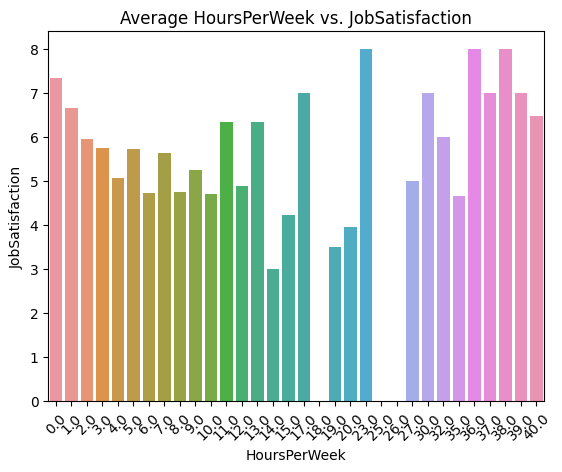

In [230]:
average_salaries = df.groupby('HoursPerWeek')['JobSatisfaction'].mean().reset_index()
# Seaborn kullanarak çubuk grafiği çizdir
sns.barplot(x='HoursPerWeek', y='JobSatisfaction', data=average_salaries)
plt.xlabel('HoursPerWeek')
plt.ylabel('JobSatisfaction')
plt.title('Average ' + str('HoursPerWeek') + ' vs. ' + str('JobSatisfaction'))
plt.xticks(rotation=45)  # Eğik olarak kategori isimlerini göster
plt.show()

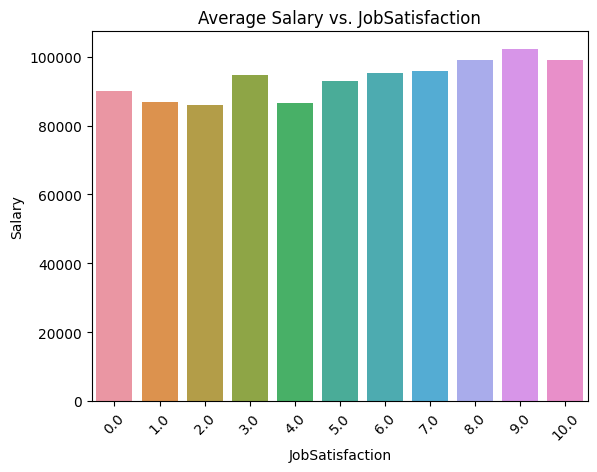

In [231]:
average_salaries = df.groupby('JobSatisfaction')['Salary'].mean().reset_index()
# Seaborn kullanarak çubuk grafiği çizdir
sns.barplot(x='JobSatisfaction', y='Salary', data=average_salaries)
plt.xlabel('JobSatisfaction')
plt.ylabel('Salary')
plt.title('Average ' + str('Salary') + ' vs. ' + str('JobSatisfaction'))
plt.xticks(rotation=45)  # Eğik olarak kategori isimlerini göster
plt.show()

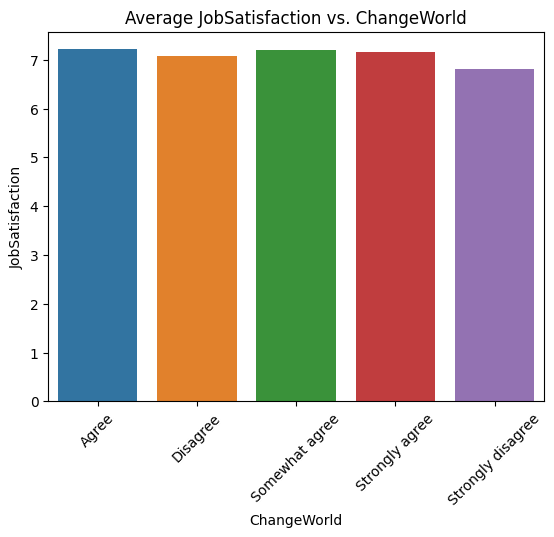

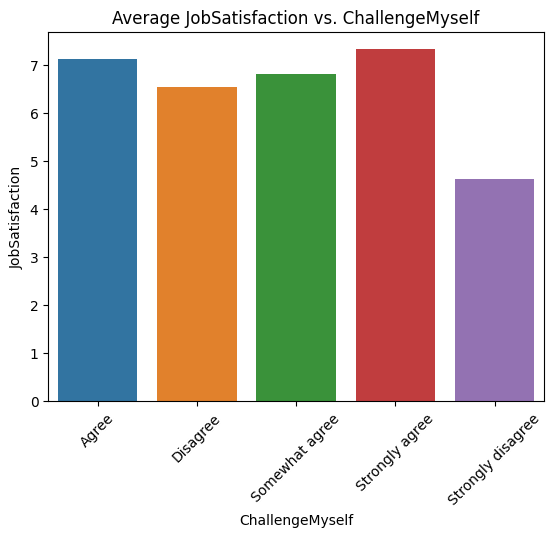

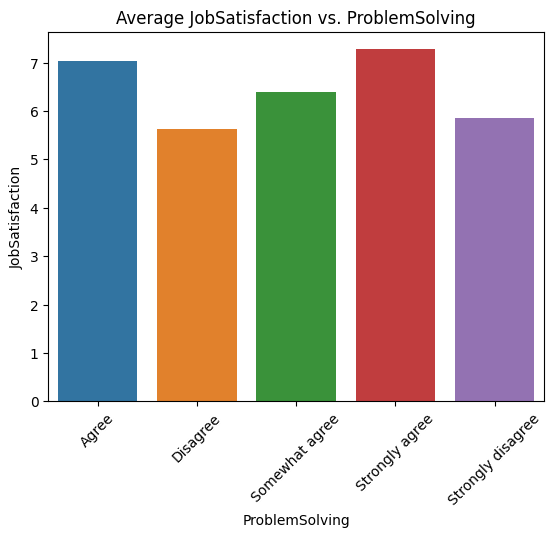

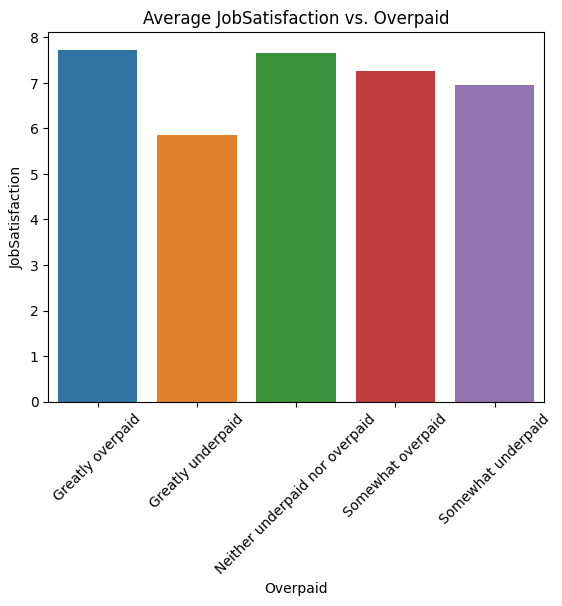

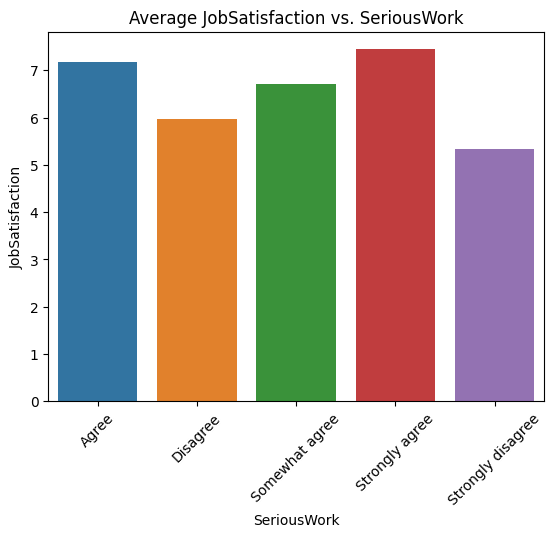

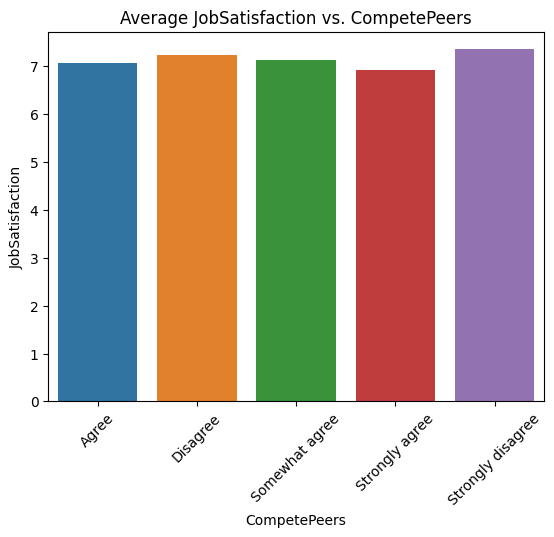

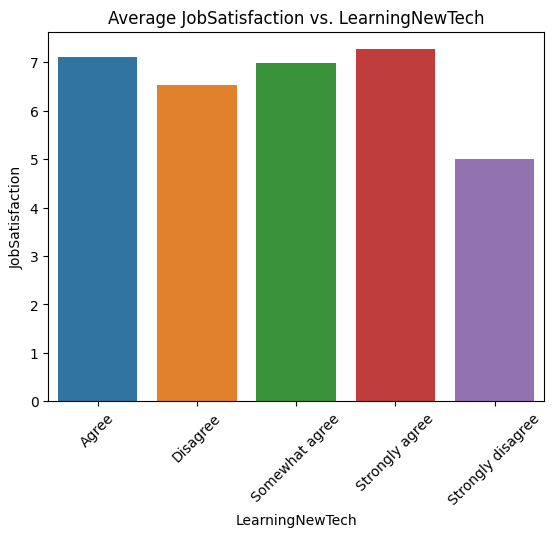

In [232]:
cat_df = work_env.select_dtypes(include=['object']).copy()
for column_name in cat_df.columns:
    average_salaries = work_env.groupby(column_name)[Output_name].mean().reset_index()
    # Seaborn kullanarak çubuk grafiği çizdir
    sns.barplot(x=column_name, y=Output_name, data=average_salaries)
    plt.xlabel(column_name)
    plt.ylabel(Output_name)
    plt.title('Average ' + str(Output_name) + ' vs. ' + str(column_name))
    plt.xticks(rotation=45)  # Eğik olarak kategori isimlerini göster
    plt.show()

In [233]:
# Step 2: Implement create_dummy_df function
def create_dummy_df(df, cat_cols, dummy_na):
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

# Step 3: Define convert_salary_to_class function
def convert_salary_to_class(salary, threshold):
    return 1 if salary >= threshold else 0

# Step 4: Implement clean_fit_logistic_mod function
def clean_fit_logistic_mod(df, response_col, cat_cols, dummy_na, salary_threshold, test_size=.3, rand_state=42):
    df = df.dropna(subset=[response_col], axis=0)
    df = df.dropna(how='all', axis=1)
    df = create_dummy_df(df, cat_cols, dummy_na)
    fill_mean = lambda col: col.fillna(col.mean())
    df = df.apply(fill_mean, axis=0)
    X = df.drop(response_col, axis=1)
    y = df[response_col].apply(lambda salary: convert_salary_to_class(salary, salary_threshold))  # Convert to binary classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    y_test_preds = log_model.predict(X_test)
    y_train_preds = log_model.predict(X_train)
    test_accuracy = accuracy_score(y_test, y_test_preds)
    train_accuracy = accuracy_score(y_train, y_train_preds)
    confusion_mat = confusion_matrix(y_test, y_test_preds)
    return test_accuracy, train_accuracy, log_model, X_train, X_test, y_train, y_test, confusion_mat


Default Salary Threshold: $7.18
Accuracy on Training Data: 59.17%
Accuracy on Test Data: 56.20%
Confusion Matrix:


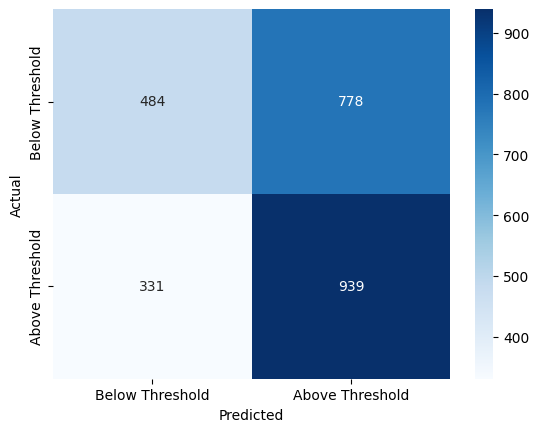

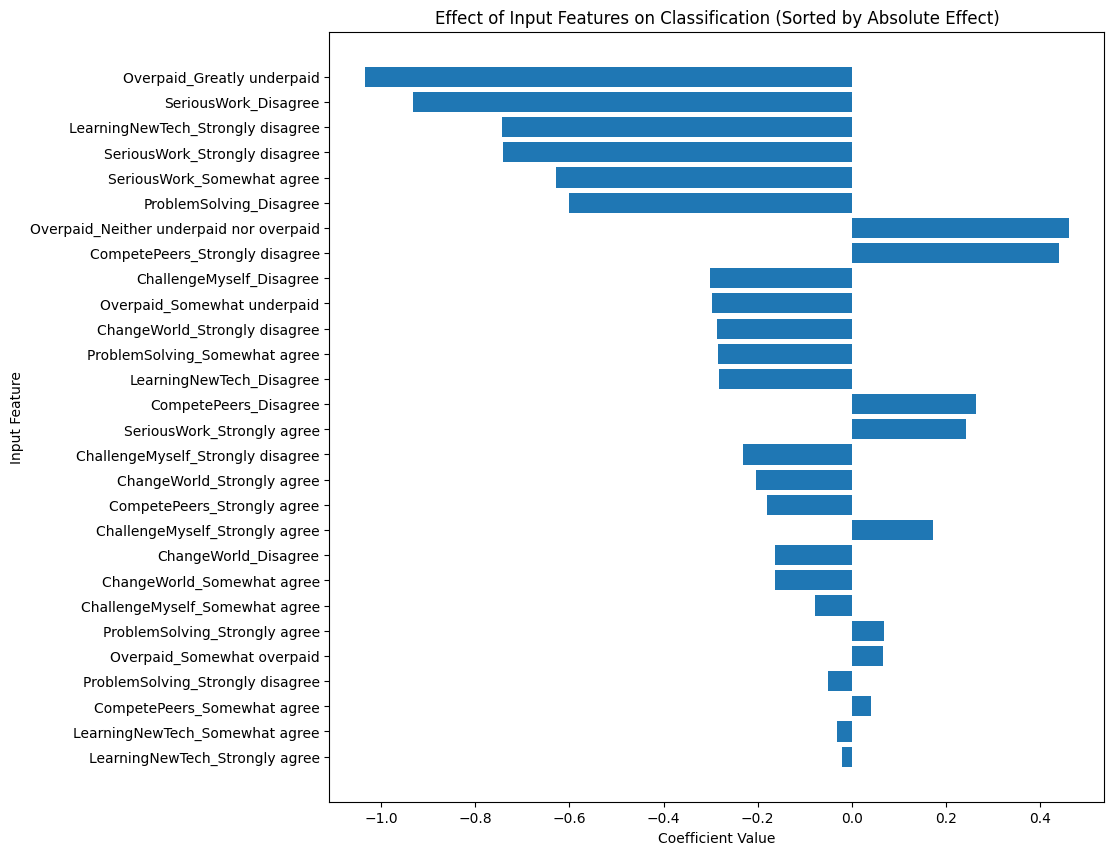

In [234]:

# Step 6: Select categorical columns
cat_df = work_env.select_dtypes(include=['object']).copy()

# Step 7: Calculate the average salary as the default threshold
threshold = df[Output_name].mean()
print("Default Salary Threshold: ${:.2f}".format(threshold))

# Step 8: Perform logistic regression classification
test_accuracy, train_accuracy, log_model, X_train, X_test, y_train, y_test, confusion_mat = clean_fit_logistic_mod(
    work_env, Output_name, cat_df, dummy_na=False, salary_threshold=threshold)

class_labels = ["Below Threshold", "Above Threshold"]


# Step 9: Print accuracy metrics
print("Accuracy on Training Data: {:.2f}%".format(train_accuracy * 100))
print("Accuracy on Test Data: {:.2f}%".format(test_accuracy * 100))

# Step 10: Visualize confusion matrix
print("Confusion Matrix:")
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 11: Visualize effect of input categories using model coefficients
coefs = log_model.coef_[0]
feature_names = X_train.columns

# Sort indices based on the absolute effect
sorted_indices = np.argsort(np.abs(coefs))

plt.figure(figsize=(10, 10))
plt.barh(np.array(feature_names)[sorted_indices], coefs[sorted_indices])
plt.xlabel("Coefficient Value")
plt.ylabel("Input Feature")
plt.title("Effect of Input Features on Classification (Sorted by Absolute Effect)")
plt.show()
